# Intel Image Classification

This Data contains around 25k images of size 150x150 distributed under 6 categories.

{'buildings' -> 0,

'forest' -> 1,

'glacier' -> 2,

'mountain' -> 3,

'sea' -> 4,

'street' -> 5 }

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [4]:
# Execute this to save new versions of the notebook
jovian.commit(project="neural-pro-2")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...


[jovian] Error: Looks like the notebook is missing output cells, please save the notebook and try jovian.commit again.


Committed successfully! https://jovian.ai/krish-vadhani/neural-pro-2


'https://jovian.ai/krish-vadhani/neural-pro-2'

In [5]:
pip install opendatasets

In [6]:
import opendatasets as od

In [7]:
import os

In [8]:
dataset_url = 'https://www.kaggle.com/puneet6060/intel-image-classification'

In [9]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: krishvadhani
Your Kaggle Key: ··········


100%|██████████| 346M/346M [00:07<00:00, 47.8MB/s]


{"username":"krishvadhani","key":"3359ad7f07c8844deea5583cd2113e54"}

In [10]:
os.listdir('./intel-image-classification/seg_train/seg_train')

['buildings', 'sea', 'mountain', 'forest', 'street', 'glacier']

In [11]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split,DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
%matplotlib inline

# Loading the Train Dataset

In [70]:
train_dataset = ImageFolder('./intel-image-classification/seg_train/seg_train',
                            tt.Compose([tt.Resize(150),
                                          tt.CenterCrop(150),tt.ToTensor()]))

In [71]:
len(train_dataset)

14034

In [72]:
train_dataset.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Loading the Test Dataset

In [170]:
test_dataset = ImageFolder('./intel-image-classification/seg_test/seg_test',
                      
                           tt.Compose([                            tt.Resize(150),
                                          tt.CenterCrop(150),tt.ToTensor()]))

In [171]:
len(test_dataset)

3000

In [172]:
test_dataset.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Understanding the Dataset

In [76]:
batch_size = 128
train_dl = DataLoader(train_dataset,batch_size,shuffle=True,num_workers=3,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [89]:
val_dl = DataLoader(test_dataset,batch_size,num_workers=3,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([3, 150, 150])
Label: buildings


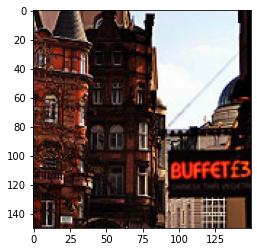

In [78]:
img, label = train_dataset[727]
print(img.shape)
plt.imshow(img.permute(1,2,0))
print('Label:',train_dataset.classes[label])

In [79]:
def show_example(img,label):
  plt.imshow(img.permute(1,2,0))
  print('Label:',train_dataset.classes[label])

Label: mountain


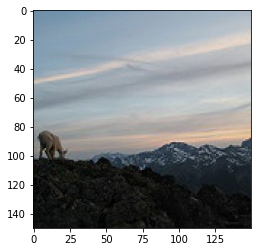

In [80]:
show_example(*train_dataset[9292])

# Loadinga btach of Images

In [81]:
def show_batch(train_dl):
  for img, label in train_dl:
    # img, label = batch
    plt.axis('off')
    plt.figure(figsize=(16,16))
    plt.imshow(make_grid(img, nrow=16).permute(1,2,0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


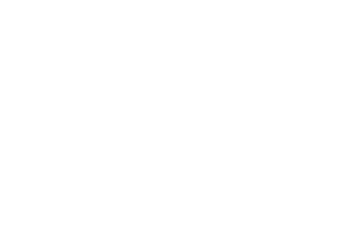

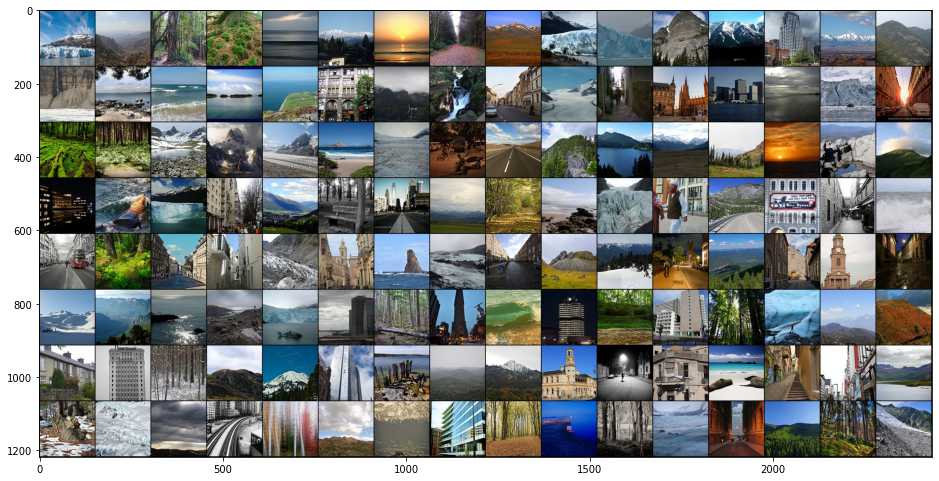

In [82]:
show_batch(train_dl)

# Training the Model

In [83]:
class ImageClassificationBase(nn.Module):
  def training_step(self,batch):
    img, label = batch
    out = self(img)
    loss = F.cross_entropy(out,label)
    return loss

  def validation_step(self,batch):
    img, label = batch
    out = self(img)
    loss = F.cross_entropy(out,label)
    acc = accuracy(out,label)
    return {'val_loss':loss,'val_acc':acc}   

  def validation_epoch_end(self,out):
    val_loss = [x['val_loss'] for x in out]
    epoch_loss = torch.stack(val_loss).mean()

    val_acc = [x['val_acc'] for x in out]
    epoch_acc = torch.stack(val_acc).mean()
    return {'val_loss':epoch_loss, 'val_acc':epoch_acc}

  def epoch_end(self,epoch,result):
    print('Epoch:[{}],val_loss:{},val_acc:{},train_loss:{}'.format(epoch,result['val_loss'],result['val_acc'],result['train_loss']))


In [84]:
def accuracy(out, label):
  _, pred = torch.max(out,dim=1)
  return torch.tensor(torch.sum(pred==label)/len(pred))

# Setting up the GPU

In [85]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [87]:
device = get_default_device()
device

device(type='cuda')

In [90]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

# We will use Resnet architecture

In [91]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,3,kernel_size=3,stride=1,padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(3,3,kernel_size=3,stride=1,padding=1)
    self.relu2 = nn.ReLU()

  def forward(self,x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.relu2(out)
    return out + x


In [92]:
simple_resnet = to_device(SimpleResidualBlock(),device)

for batch in train_dl:
  img, label = batch
  out = simple_resnet(img)
  print(out.shape)
  break

del simple_resnet,img, label
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 3, 150, 150])


In [105]:
def conv_block(in_channel, out_channel,pool=False):
  layers = [nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1,stride=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)]

  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers) 

In [118]:
class Resnet9(ImageClassificationBase):
  def __init__(self,in_channel,num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channel,32)
    self.conv2 = conv_block(32,64,pool=True)
    self.res1 = nn.Sequential(conv_block(64,64),conv_block(64,64))

    self.conv3 = conv_block(64,128,pool=True)
    self.conv4 = conv_block(128,256,pool=True)
    self.res2 = nn.Sequential(conv_block(256,256),conv_block(256,256))

    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(256*16,num_classes))
    
  def forward(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out

    out = self.classifier(out)

    return out

In [119]:
model = to_device(Resnet9(3,6),device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [120]:
@torch.no_grad()
def evaluate(model,val_dl):
  model.eval()
  out = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(out)

In [121]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [122]:
def fit(epochs,model,max_lr,train_dl,val_dl,weight_decay=0,grad_clip=None,opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(),max_lr)
    history = []
    torch.cuda.empty_cache()

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dl))

    for epoch in range(epochs):
        train_loss = []
        model.train()
        lrs = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model,val_dl)
        result['train_loss'] = torch.stack(train_loss).mean()
        result['lrs'] = lrs
        model.epoch_end(epoch,result)
        history.append(result)

    return history

In [123]:
hist = [evaluate(model,val_dl)]
hist

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


[{'val_acc': tensor(0.1727, device='cuda:0'),
  'val_loss': tensor(1.7916, device='cuda:0')}]

In [124]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam    

In [125]:
hist += fit(epochs,model,1e-2,train_dl,val_dl,weight_decay=weight_decay,opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch:[0],val_loss:1.495352029800415,val_acc:0.5102306604385376,train_loss:1.0142076015472412
Epoch:[1],val_loss:0.7974737882614136,val_acc:0.7073568105697632,train_loss:0.8655821084976196
Epoch:[2],val_loss:0.7697924375534058,val_acc:0.7635788917541504,train_loss:0.7719530463218689
Epoch:[3],val_loss:0.5341274738311768,val_acc:0.8180338740348816,train_loss:0.5290244221687317
Epoch:[4],val_loss:1.054277777671814,val_acc:0.6759672164916992,train_loss:0.45108485221862793
Epoch:[5],val_loss:0.39715155959129333,val_acc:0.8585844039916992,train_loss:0.3873315155506134
Epoch:[6],val_loss:0.38657039403915405,val_acc:0.8623511791229248,train_loss:0.33447104692459106
Epoch:[7],val_loss:0.3285313546657562,val_acc:0.8850911855697632,train_loss:0.28299230337142944
Epoch:[8],val_loss:0.31752559542655945,val_acc:0.8884859085083008,train_loss:0.2358400821685791
Epoch:[9],val_loss:0.3157236576080322,val_acc:0.8920666575431824,train_loss:0.2020503431558609


# So here we are getting an accuarcy of almost 90% on test dataset

In [174]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0),device)
    yb = model(xb)
    _, pred = torch.max(yb,dim=1)
    return train_dataset.classes[pred[0].item()]

Label: glacier Prediction: glacier


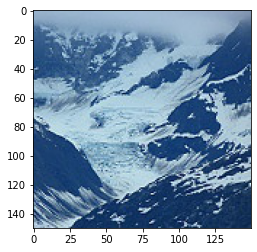

In [181]:
img, label = test_dataset[1251]
plt.imshow(img.permute(1,2,0))
print('Label:',train_dataset.classes[label],'Prediction:',predict_image(img,model))

In [182]:
def plot_accuracies(history):
  acc = [x['val_acc'] for x in history]
  plt.plot(acc, '-rx')
  plt.xlabel = 'epoch'
  plt.ylabel = 'accuracy'
  plt.title = 'accuracy vs epoch'

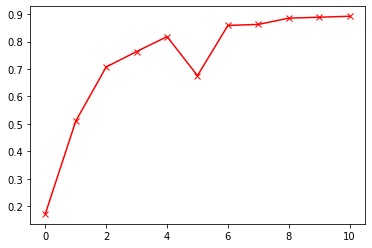

In [183]:
plot_accuracies(hist)

In [192]:
def plot_losses(history):
  val_loss = [x['val_loss'] for x in history]
  train_loss = [x.get('train_loss') for x in history]
  plt.plot(val_loss,'-rx')
  plt.plot(train_loss, '-y*')
  plt.xlabel = 'epoch'
  plt.ylabel = 'losses'
  plt.title = 'losses vs epoch'
  plt.legend(['Val_loss','train_loss'])

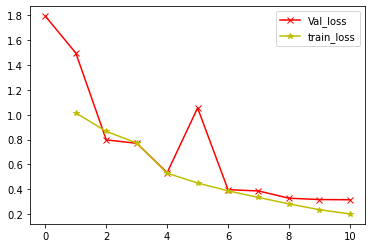

In [193]:
plot_losses(hist)